# How to use Machine Learning for Time Series Forecasting

## Dataset: Hourly Energy Consumption 
### Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

- Exponential trend
- Increase linear trend
- Seasonal Pattern
- Seasonal Pattern with Increase linear trend

In [3]:
# Read dataset
df = pd.read_csv('../data/AEP_hourly.csv')

# Set date columns as index
df = df.set_index('Datetime')

# Format index as datetime
df.index = pd.to_datetime(df.index)

In [4]:
# Data from 2004
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [5]:
# Data up to 2018
df.tail()

,AEP_MW
Datetime,
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0
2018-01-01 23:00:00,20415.0
2018-01-02 00:00:00,19993.0


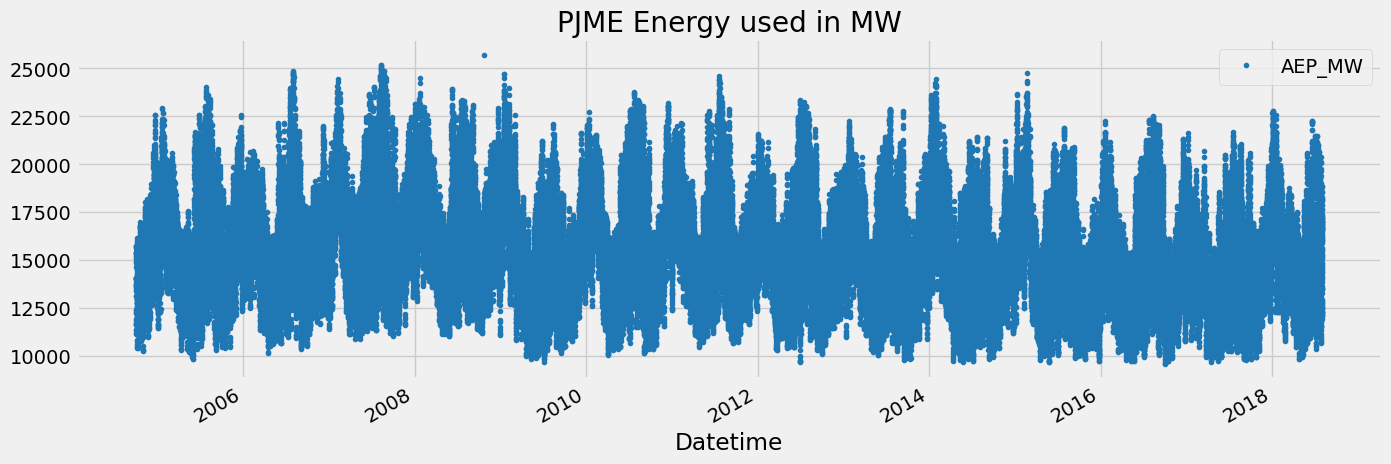

In [6]:
# Plot the data
df.plot(style='.', figsize=(15, 5), 
        color=color_pal[0], 
        title='PJME Energy used in MW')

plt.show()

In [7]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

# Train / Test Split 

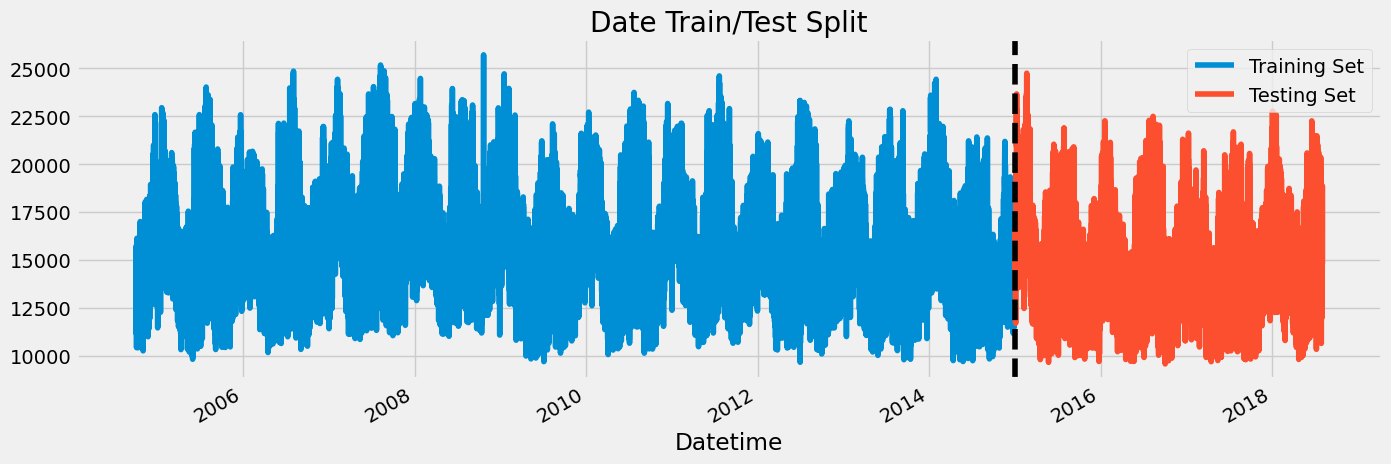

In [8]:
# Split on the date January 2015
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Date Train/Test Split')
test.plot(ax=ax, label='Testing Set')
ax.axvline('01-01-2015',color='black', ls='--')
ax.legend(['Training Set','Testing Set'])
plt.show()

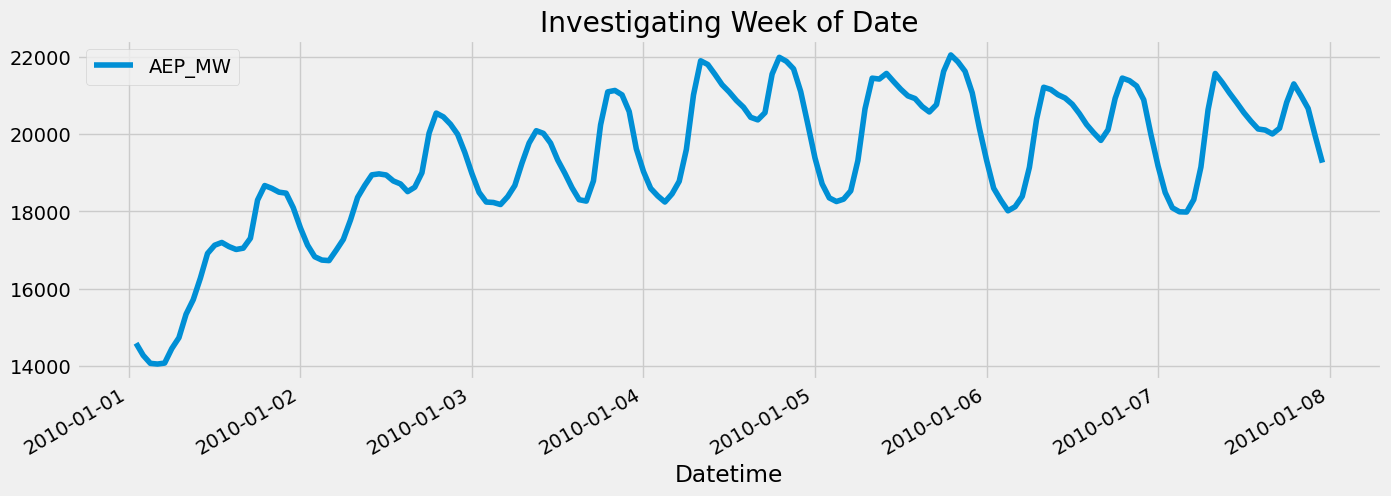

In [9]:
# Investiganting one week of the dataset to see weekly pattern
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Investigating Week of Date')
plt.show()

# Feature Creation

In [10]:
# Funtion to create new attributes based on index
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week # Monday 0 and Sunday 6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

# Call the function
df = create_features(df)

In [11]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1


# Visualize Feature Vs Target Relationship

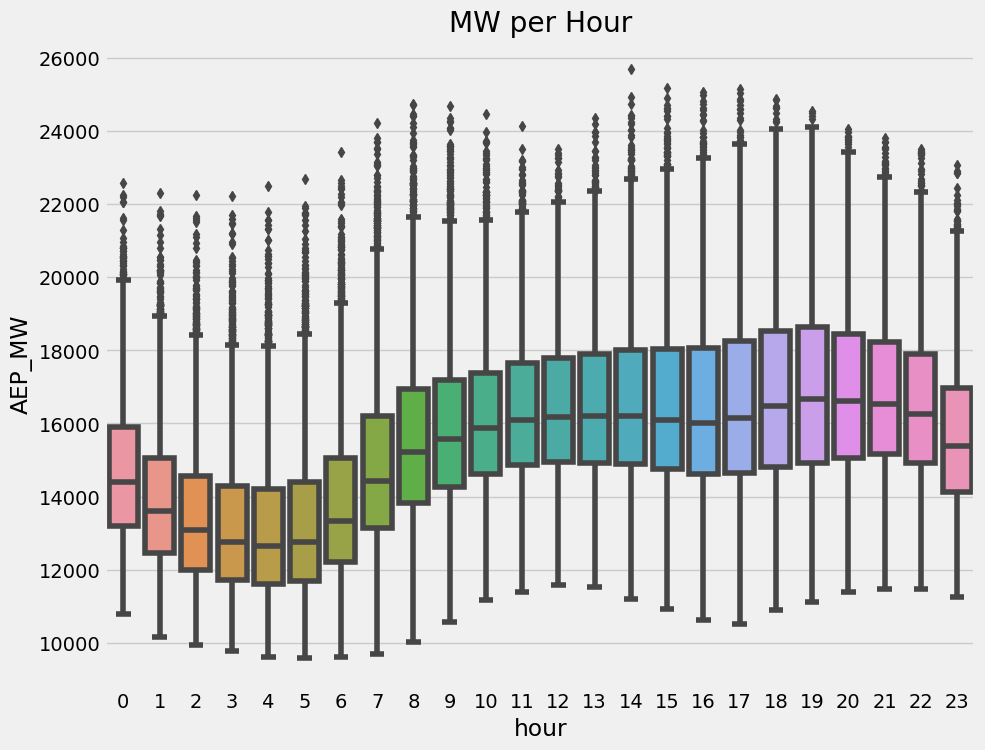

In [12]:
# Per Hour
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='AEP_MW')
ax.set_title('MW per Hour')
plt.show()

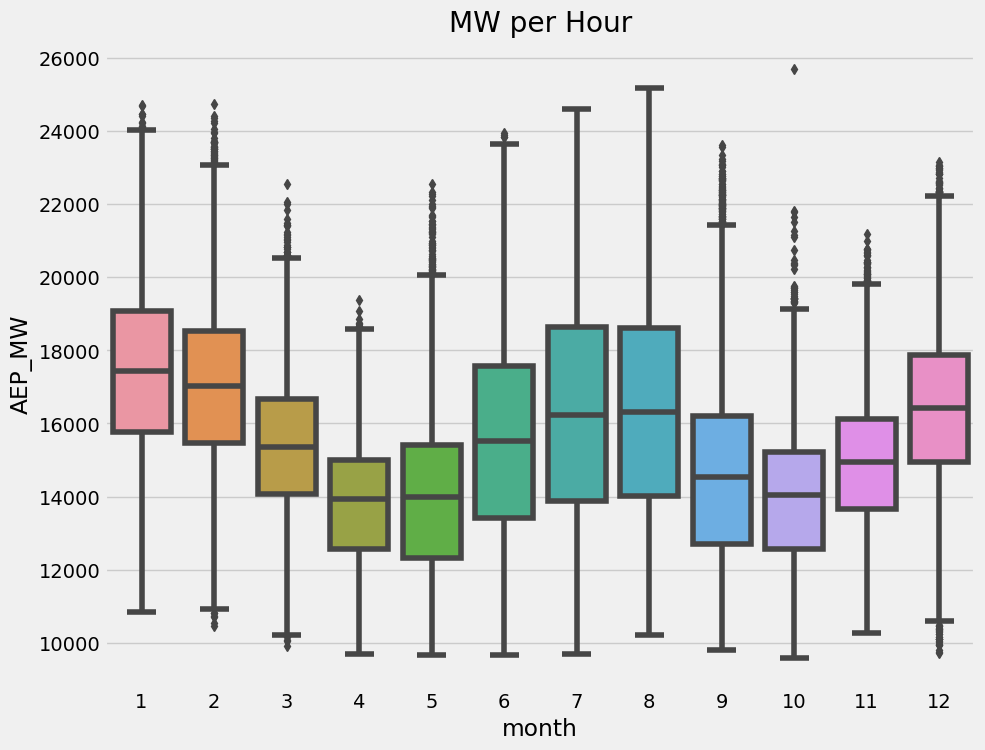

In [13]:
# Per Month
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='AEP_MW')
ax.set_title('MW per Hour')
plt.show()

# Create Time Series Model

In [14]:
# Create train and test dataframes
train = create_features(train) # data before '01-01-2015'
test = create_features(test) # data equal or after '01-01-2015'

In [15]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [16]:
# Define target variable and features to split the X and y train and test
FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET='AEP_MW'

In [17]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000,
        early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train),(X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.93868
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.83339
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1644.49126
[544]	validation_0-rmse:1091.83993	validation_1-rmse:1647.10973


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importances

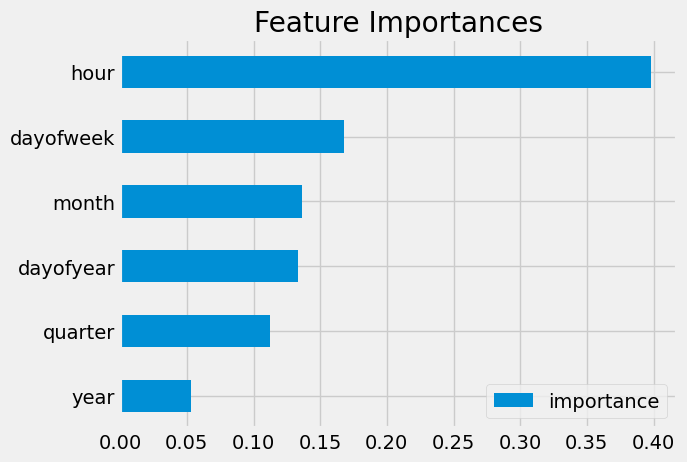

In [19]:
# Use the regressor model to display feature importannces (fi)
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values(by='importance').plot(kind='barh', title='Feature Importances')
plt.show()

# Forecast on Test

In [20]:
test['predictions'] = reg.predict(X_test)

In [21]:
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,predictions
Datetime,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18112.775391
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18112.775391
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17780.941406


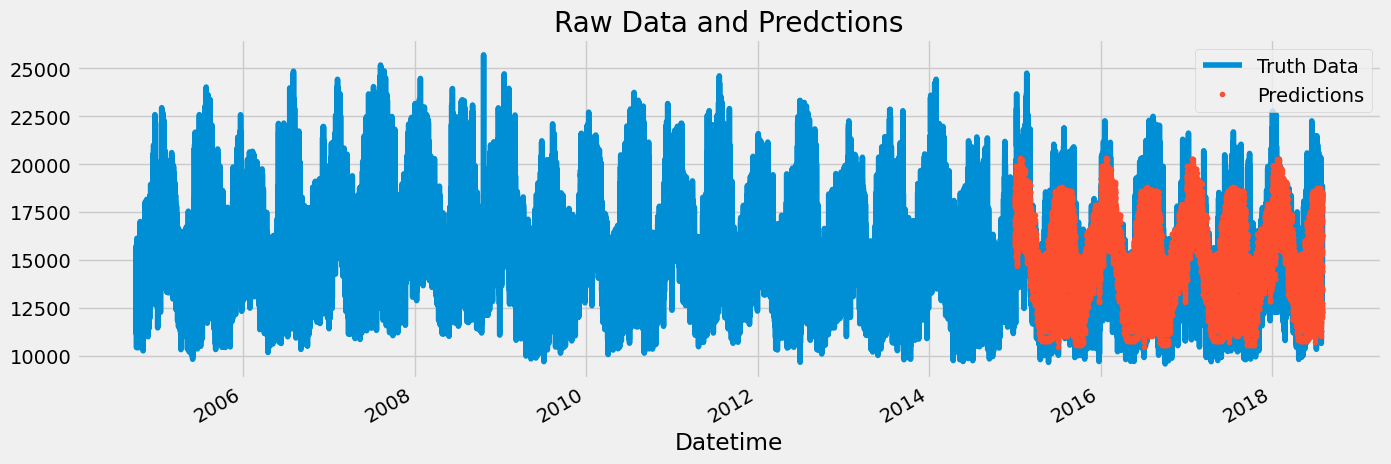

In [22]:
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and Predctions')
plt.show()

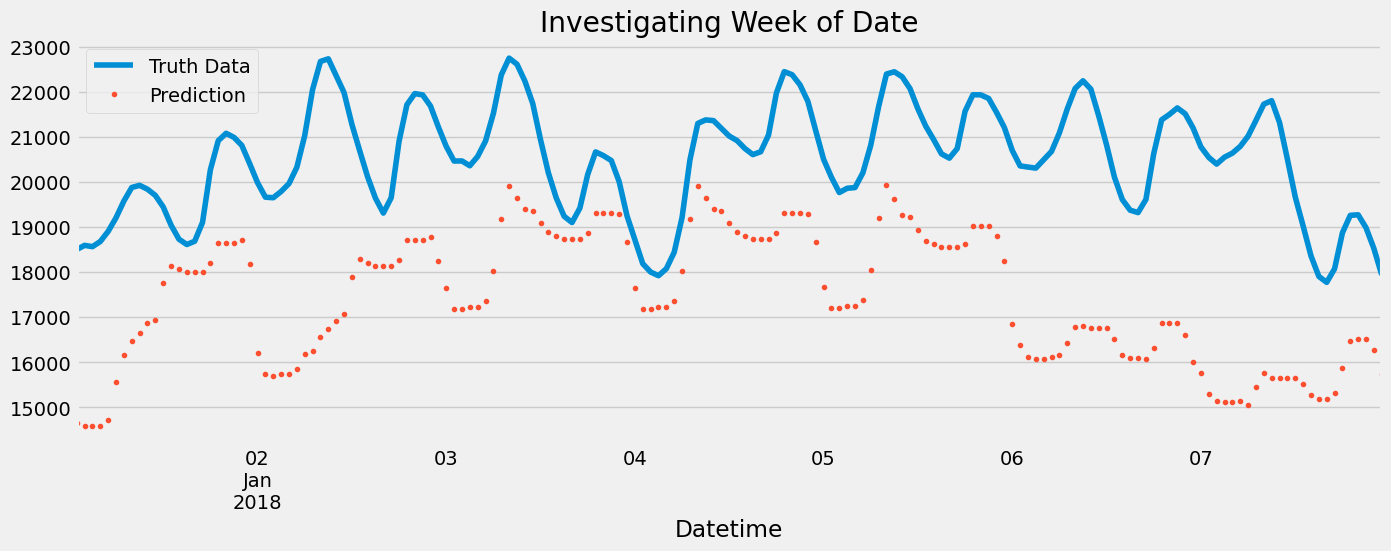

In [23]:
# Investiganting one week of the dataset again
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['AEP_MW'] \
    .plot(figsize=(15,5), title='Investigating Week of Date')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [24]:
score = np.sqrt(mean_squared_error(test['AEP_MW'],test['predictions']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 1644.39


# Calculate Error

In [25]:
test['error'] = np.abs(test[TARGET] - test['predictions'])

In [26]:
test['date'] = test.index.date

In [27]:
# the worst prediction
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2017-01-22    4872.108968
2015-02-20    4861.401571
2015-02-19    4769.359985
2018-01-06    4403.549683
2017-02-07    4290.881022
Name: error, dtype: float64

In [28]:
# the best prediction
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2017-12-24    222.424520
2016-12-13    236.145426
2017-03-18    242.976603
2017-10-05    243.126994
2017-10-15    273.699788
Name: error, dtype: float64

**Next Steps:**
- More robust cross validation
- Add more feature (weather forecast, holidays)